In [1]:
import pandas as pd
import urllib.request
import zipfile
url = 'https://github.com/mattharrison/datasets/raw/master/data/'\
'kaggle-survey-2018.zip'
fname = 'kaggle-survey-2018.zip'
member_name = 'multipleChoiceResponses.csv'
def extract_zip(src, dst, member_name):
    url = src
    fname = dst
    fin = urllib.request.urlopen(url)
    data = fin.read()
    with open(dst, mode='wb') as fout:
        fout.write(data)
    with zipfile.ZipFile(dst) as z:
        kag = pd.read_csv(z.open(member_name),low_memory=False)
        kag_questions = kag.iloc[0]
        raw = kag.iloc[1:]
        return raw

raw = extract_zip(url, fname, member_name)

In [3]:
raw

,Time from Start to Finish (seconds),Q1,Q1_OTHER_TEXT,Q2,Q3,Q4,Q5,Q6,Q6_OTHER_TEXT,Q7,...,Q49_OTHER_TEXT,Q50_Part_1,Q50_Part_2,Q50_Part_3,Q50_Part_4,Q50_Part_5,Q50_Part_6,Q50_Part_7,Q50_Part_8,Q50_OTHER_TEXT
1,710,Female,-1,45-49,United States of America,Doctoral degree,Other,Consultant,-1,Other,...,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1
2,434,Male,-1,30-34,Indonesia,Bachelor’s degree,Engineering (non-computer focused),Other,0,Manufacturing/Fabrication,...,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1
3,718,Female,-1,30-34,United States of America,Master’s degree,"Computer science (software engineering, etc.)",Data Scientist,-1,I am a student,...,-1,NaN,Too time-consuming,NaN,NaN,NaN,NaN,NaN,NaN,-1
4,621,Male,-1,35-39,United States of America,Master’s degree,"Social sciences (anthropology, psychology, soc...",Not employed,-1,NaN,...,-1,NaN,NaN,Requires too much technical knowledge,NaN,Not enough incentives to share my work,NaN,NaN,NaN,-1
5,731,Male,-1,22-24,India,Master’s degree,Mathematics or statistics,Data Analyst,-1,I am a student,...,-1,NaN,Too time-consuming,NaN,NaN,Not enough incentives to share my work,NaN,NaN,NaN,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23855,575,Male,-1,45-49,France,Doctoral degree,"Computer science (software engineering, etc.)",Chief Officer,-1,Computers/Technology,...,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1
23856,131,Female,-1,25-29,Turkey,Master’s degree,Engineering (non-computer focused),NaN,-1,NaN,...,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1
23857,370,Male,-1,22-24,Turkey,Master’s degree,"Computer science (software engineering, etc.)",Software Engineer,-1,Computers/Technology,...,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1
23858,36,Male,-1,25-29,United Kingdom of Great Britain and Northern I...,NaN,NaN,NaN,-1,NaN,...,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1


In [4]:
raw['Q5'].pipe(topn,n=3)

NameError: name 'topn' is not defined

In [2]:
raw.Q5.value_counts()

Q5
Computer science (software engineering, etc.)                    9430
Engineering (non-computer focused)                               3705
Mathematics or statistics                                        2950
A business discipline (accounting, economics, finance, etc.)     1791
Physics or astronomy                                             1110
Information technology, networking, or system administration     1029
Medical or life sciences (biology, chemistry, medicine, etc.)     871
Other                                                             770
Social sciences (anthropology, psychology, sociology, etc.)       554
Humanities (history, literature, philosophy, etc.)                269
Environmental science or geology                                  253
I never declared a major                                          128
Fine arts or performing arts                                       87
Name: count, dtype: int64

In [3]:
def topn(ser, n=5, default='other'):
    counts = ser.value_counts()
    return ser.where(ser.isin(counts.index[:n]), default)

In [4]:
def tweak_kag(df_: pd.DataFrame) -> pd.DataFrame:
    """
    Tweak the Kaggle survey data and return a new DataFrame.
    This function takes a Pandas DataFrame containing Kaggle
    survey data as input and returns a new DataFrame. The
    modifications include extracting and transforming certain
    columns, renaming columns, and selecting a subset of columns.
    Parameters
    ----------
    df_ : pd.DataFrame
    The input DataFrame containing Kaggle survey data.
    Returns
    -------
    pd.DataFrame
    The new DataFrame with the modified and selected columns.
    """
    return (
        df_.assign(
            age=df_.Q2.str.slice(0,2).astype(int),
            education=df_.Q4.replace({'Master’s degree': 18,
                'Bachelor’s degree': 16,
                'Doctoral degree': 20,
                'Some college/university study without earning a bachelor’s degree': 13,
                'Professional degree': 19,
                'I prefer not to answer': None,
                'No formal education past high school': 12}),
            major=(df_.Q5
                .pipe(topn, n=3)
                .replace({
                    'Computer science (software engineering, etc.)': 'cs',
                    'Engineering (non-computer focused)': 'eng',
                    'Mathematics or statistics': 'stat'})
                ),
            years_exp=(df_.Q8.str.replace('+','', regex=False)
                .str.split('-', expand=True)
                .iloc[:,0]
                .astype(float)),
            compensation=(df_.Q9.str.replace('+','', regex=False)
                .str.replace(',','', regex=False)
                .str.replace('500000', '500', regex=False)
                .str.replace('I do not wish to disclose my approximate yearly compensation',
                '0', regex=False)
                .str.split('-', expand=True)
                .iloc[:,0]
                .fillna(0)
                .astype(int)
                .mul(1_000)
                ),
            python=df_.Q16_Part_1.fillna(0).replace('Python', 1),
            r=df_.Q16_Part_2.fillna(0).replace('R', 1),
            sql=df_.Q16_Part_3.fillna(0).replace('SQL', 1)
        )#assign
        .rename(columns=lambda col:col.replace(' ', '_'))
        .loc[:, 'Q1,Q3,age,education,major,years_exp,compensation,'
        'python,r,sql'.split(',')]
    )


In [5]:
from sklearn import base, pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder 

In [6]:
class TweakKagTransformer(base.BaseEstimator, base.TransformerMixin):

    def __init__(self, ycol=None):
        self.ycol = ycol

    def transform(self, X):
        return tweak_kag(X)

    def fit(self, X, y=None):
        return self


In [7]:
trans=TweakKagTransformer()

In [8]:
trans.fit_transform(raw)

C:\Users\Administrator\AppData\Local\Temp\ipykernel_6788\3735404497.py:20: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  education=df_.Q4.replace({'Master’s degree': 18,
C:\Users\Administrator\AppData\Local\Temp\ipykernel_6788\3735404497.py:49: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  python=df_.Q16_Part_1.fillna(0).replace('Python', 1),
C:\Users\Administrator\AppData\Local\Temp\ipykernel_6788\3735404497.py:50: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain th

,Q1,Q3,age,education,major,years_exp,compensation,python,r,sql
1,Female,United States of America,45,20.0,other,NaN,0,0,0,0
2,Male,Indonesia,30,16.0,eng,5.0,10000,0,0,1
3,Female,United States of America,30,18.0,cs,0.0,0,0,1,0
4,Male,United States of America,35,18.0,other,NaN,0,1,1,1
5,Male,India,22,18.0,stat,0.0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...
23855,Male,France,45,20.0,cs,5.0,250000,1,1,1
23856,Female,Turkey,25,18.0,eng,NaN,0,0,0,0
23857,Male,Turkey,22,18.0,cs,0.0,10000,0,0,0
23858,Male,United Kingdom of Great Britain and Northern I...,25,NaN,other,NaN,0,0,0,0


In [9]:
def get_rawX_y(df, y_col):
    raw = (df
    .query('Q3.isin(["United States of America", "China", "India"]) '
    'and Q6.isin(["Data Scientist", "Software Engineer"])')
    )
    return raw.drop(columns=[y_col]), raw[y_col]

In [10]:
%pip install feature_engine

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [11]:
from feature_engine import encoding, imputation

In [12]:
## Create a pipeline
kag_pl = pipeline.Pipeline(
    [('tweak', TweakKagTransformer()),
    ('cat', encoding.OneHotEncoder(top_categories=5,
    variables=['Q1', 'Q3', 'major'])),
    ('num_impute', imputation.MeanMedianImputer(imputation_method='median',
                                                variables=['education', 'years_exp']))]
)

In [13]:
from sklearn import model_selection
kag_X, kag_y = get_rawX_y(raw, 'Q6')

In [14]:
kag_X_train, kag_X_test, kag_y_train, kag_y_test = \
model_selection.train_test_split(
kag_X, kag_y, test_size=.3, random_state=42, stratify=kag_y)

In [15]:
X_train = kag_pl.fit_transform(kag_X_train, kag_y_train)

C:\Users\Administrator\AppData\Local\Temp\ipykernel_6788\3735404497.py:20: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  education=df_.Q4.replace({'Master’s degree': 18,
C:\Users\Administrator\AppData\Local\Temp\ipykernel_6788\3735404497.py:49: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  python=df_.Q16_Part_1.fillna(0).replace('Python', 1),
C:\Users\Administrator\AppData\Local\Temp\ipykernel_6788\3735404497.py:50: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain th

In [16]:
X_test = kag_pl.transform(kag_X_test)

C:\Users\Administrator\AppData\Local\Temp\ipykernel_6788\3735404497.py:20: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  education=df_.Q4.replace({'Master’s degree': 18,
C:\Users\Administrator\AppData\Local\Temp\ipykernel_6788\3735404497.py:49: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  python=df_.Q16_Part_1.fillna(0).replace('Python', 1),
C:\Users\Administrator\AppData\Local\Temp\ipykernel_6788\3735404497.py:50: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain th

In [17]:
print(X_train)

       age  education  years_exp  compensation  python  r  sql  Q1_Male  \
587     25       18.0        4.0             0       1  0    1        1   
3065    22       16.0        1.0         10000       1  0    0        1   
8435    22       18.0        1.0             0       1  0    0        1   
3110    40       20.0        3.0        125000       1  0    1        0   
16372   45       12.0        5.0        100000       1  0    1        1   
...    ...        ...        ...           ...     ... ..  ...      ...   
16608   25       16.0        2.0         10000       0  0    1        1   
7325    18       16.0        1.0         30000       1  0    1        1   
21810   18       16.0        2.0             0       0  0    0        1   
4917    25       18.0        1.0        100000       1  0    1        1   
639     25       18.0        1.0         10000       1  0    0        0   

       Q1_Female  Q1_Prefer not to say  Q1_Prefer to self-describe  \
587            0             

In [18]:
kag_y_train

587      Software Engineer
3065        Data Scientist
8435        Data Scientist
3110        Data Scientist
16372    Software Engineer
               ...        
16608    Software Engineer
7325     Software Engineer
21810       Data Scientist
4917        Data Scientist
639         Data Scientist
Name: Q6, Length: 2110, dtype: object

In [19]:
type(kag_y_train)

pandas.core.series.Series

In [20]:
kag_y_train.nunique()

2

In [21]:
%pip install jinja2

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [22]:
(
X_train
.assign(data_scientist = kag_y_train == 'Data Scientist')
.corr(method='spearman')
.style
.background_gradient(cmap='RdBu', vmax=1, vmin=-1)
.set_sticky(axis='index')
)

,age,education,years_exp,compensation,python,r,sql,Q1_Male,Q1_Female,Q1_Prefer not to say,Q1_Prefer to self-describe,Q3_United States of America,Q3_India,Q3_China,major_cs,major_other,major_eng,major_stat,data_scientist
age,1.000000,0.345717,0.644863,0.451349,0.046651,0.127667,0.134325,0.014277,-0.033693,0.051232,0.041474,0.371123,-0.363626,-0.023384,-0.223529,0.201910,0.006262,0.073864,0.075440
education,0.345717,1.000000,0.098849,0.241393,0.060259,0.151244,0.066620,-0.079534,0.064777,0.060984,0.002701,0.272790,-0.273408,-0.006441,-0.216724,0.164771,-0.001043,0.121294,0.266717
years_exp,0.644863,0.098849,1.000000,0.255164,-0.055408,0.012090,0.050181,0.083624,-0.097564,0.034470,0.016784,0.117912,-0.136666,0.029630,-0.046551,0.018267,0.004264,0.042917,-0.145461
compensation,0.451349,0.241393,0.255164,1.000000,0.165070,0.171485,0.201336,0.000967,0.002912,-0.035554,0.049881,0.616759,-0.556154,-0.123281,-0.225934,0.241580,-0.060256,0.109100,0.174434
python,0.046651,0.060259,-0.055408,0.165070,1.000000,0.183665,0.287957,0.039944,-0.039207,-0.006729,-0.000553,0.052339,-0.043101,-0.017642,-0.095136,0.093887,0.008640,0.013474,0.121741
r,0.127667,0.151244,0.012090,0.171485,0.183665,1.000000,0.276862,-0.066982,0.068157,0.004831,-0.004454,0.178682,-0.105625,-0.133029,-0.205538,0.139994,-0.022082,0.162942,0.329124
sql,0.134325,0.066620,0.050181,0.201336,0.287957,0.276862,1.000000,-0.026692,0.032639,-0.010814,-0.018499,0.166587,-0.107382,-0.108406,-0.130081,0.109862,-0.012964,0.073906,0.117941
Q1_Male,0.014277,-0.079534,0.083624,0.000967,0.039944,-0.066982,-0.026692,1.000000,-0.957007,-0.222963,-0.094664,-0.144665,0.116961,0.052566,0.062605,-0.071139,0.028492,-0.039544,-0.091126
Q1_Female,-0.033693,0.064777,-0.097564,0.002912,-0.039207,0.068157,0.032639,-0.957007,1.000000,-0.045225,-0.019201,0.131051,-0.105490,-0.048434,-0.049753,0.064054,-0.034760,0.036779,0.086614
Q1_Prefer not to say,0.051232,0.060984,0.034470,-0.035554,-0.006729,0.004831,-0.010814,-0.222963,-0.045225,1.000000,-0.004473,0.046366,-0.038587,-0.014918,-0.045908,0.010336,0.029149,0.021052,0.018540


In [23]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2110 entries, 587 to 639
Data columns (total 18 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   age                          2110 non-null   int64  
 1   education                    2110 non-null   float64
 2   years_exp                    2110 non-null   float64
 3   compensation                 2110 non-null   int64  
 4   python                       2110 non-null   int64  
 5   r                            2110 non-null   int64  
 6   sql                          2110 non-null   int64  
 7   Q1_Male                      2110 non-null   int64  
 8   Q1_Female                    2110 non-null   int64  
 9   Q1_Prefer not to say         2110 non-null   int64  
 10  Q1_Prefer to self-describe   2110 non-null   int64  
 11  Q3_United States of America  2110 non-null   int64  
 12  Q3_India                     2110 non-null   int64  
 13  Q3_China              

<Axes: xlabel='r'>

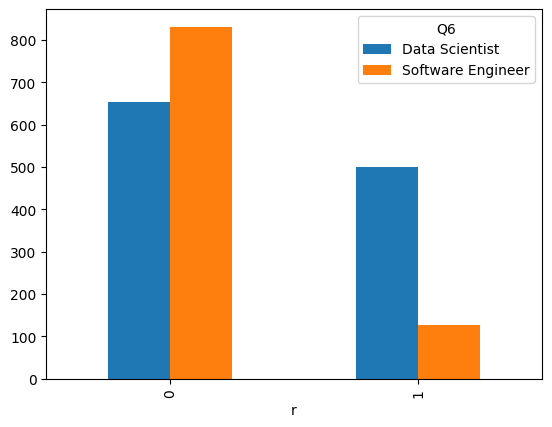

In [24]:
pd.crosstab(index=X_train['r'],columns=kag_y_train).plot.bar()

<Axes: xlabel='r'>

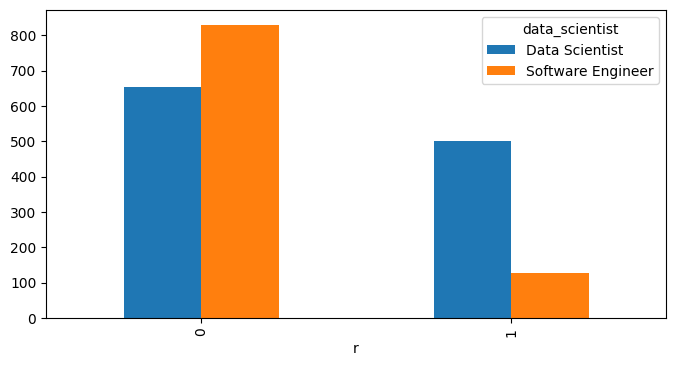

In [25]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(8, 4))
(X_train
.assign(data_scientist = kag_y_train)
.groupby('r')
.data_scientist
.value_counts()
.unstack()
.plot.bar(ax=ax)
)

In [26]:
X_train['major_cs']

587      0
3065     1
8435     0
3110     0
16372    0
        ..
16608    1
7325     1
21810    1
4917     0
639      1
Name: major_cs, Length: 2110, dtype: int64

In [27]:
pd.crosstab(index=X_train['major_cs'],
            columns=kag_y)

Q6,Data Scientist,Software Engineer
major_cs,,
0,800,361
1,353,596


<Axes: xlabel='major_cs'>

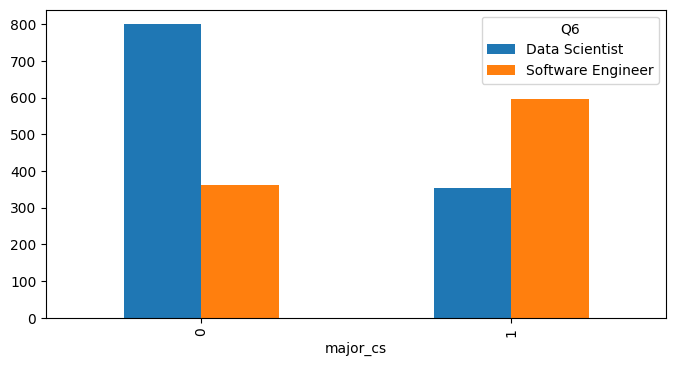

In [28]:
fig, ax = plt.subplots(figsize=(8, 4))

(
pd.crosstab(index=X_train['major_cs'],
            columns=kag_y)
.plot.bar(ax=ax)
)

<Axes: xlabel='years_exp', ylabel='compensation'>

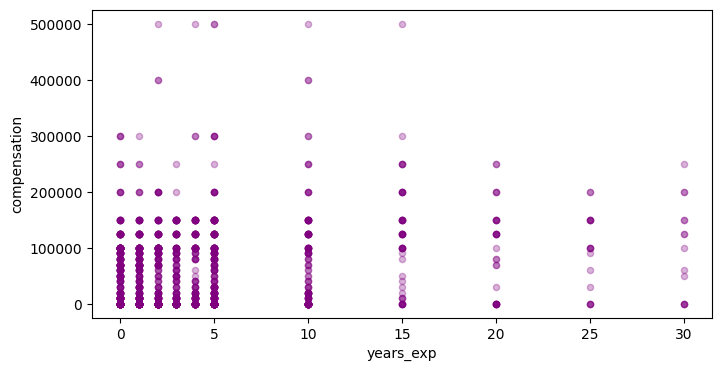

In [29]:
fig, ax = plt.subplots(figsize=(8, 4))
(X_train
.plot.scatter(x='years_exp', y='compensation', alpha=.3, ax=ax, c='purple')
)

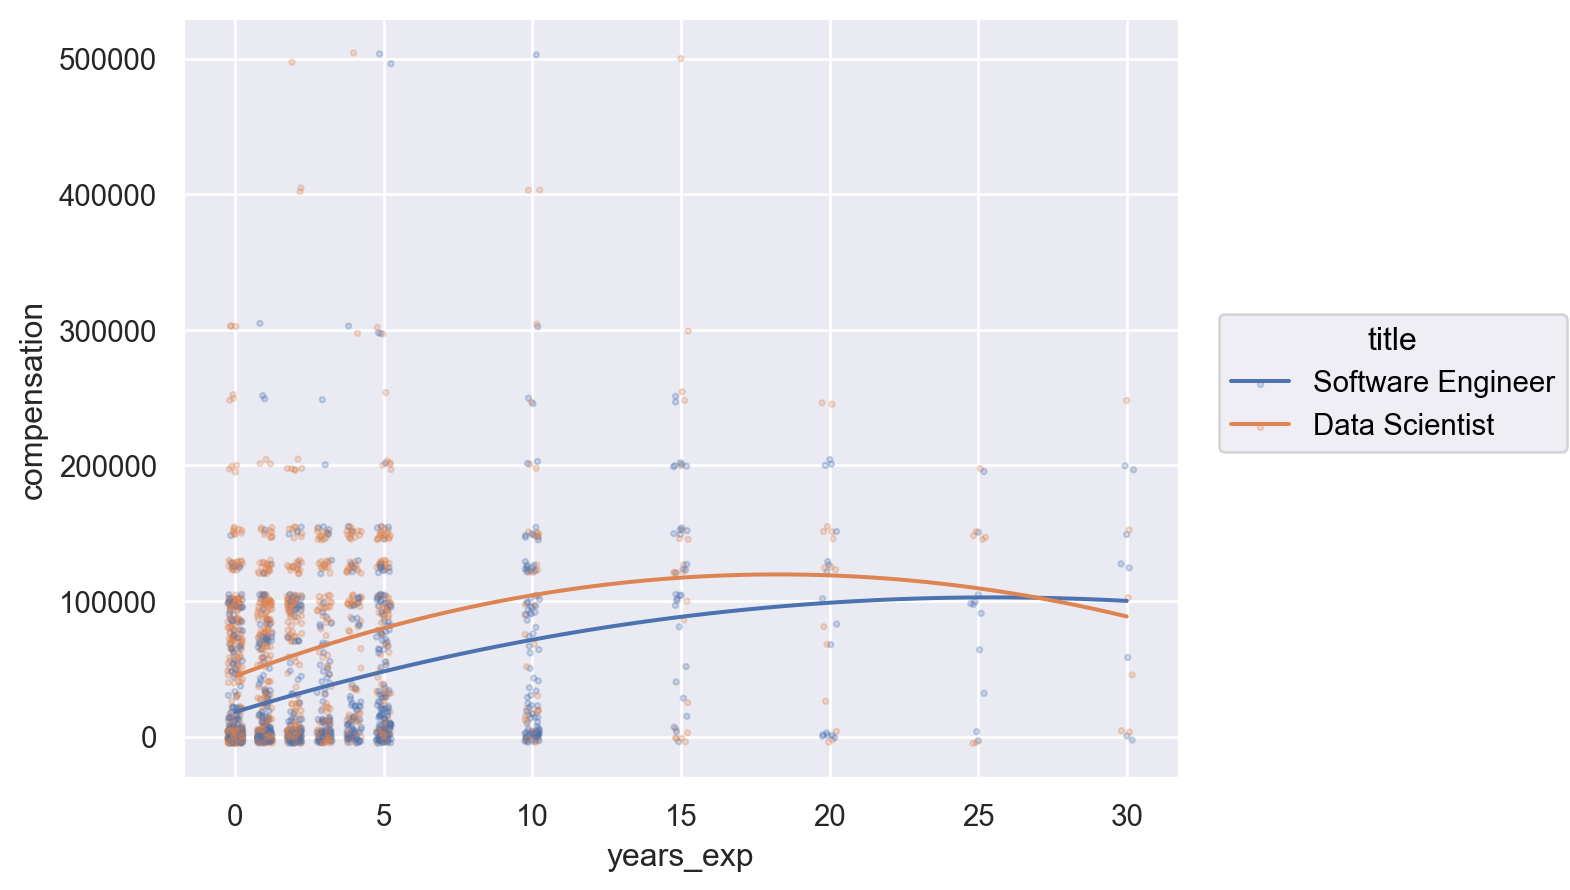

<Figure size 800x400 with 0 Axes>

In [31]:
import seaborn.objects as so
fig = plt.figure(figsize=(8, 4))
(so
.Plot(X_train.assign(title=kag_y_train), x='years_exp', y='compensation', color='title')
.add(so.Dots(alpha=.3, pointsize=2), so.Jitter(x=.5, y=10_000))
.add(so.Line(), so.PolyFit())
#.on(fig) # not required unless saving to image
.plot() # ditto
)